In [3]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
"""
!python3 -V

Python 3.11.4


In [1]:
import numpy as np
import os

from tqdm import tqdm

# Scalar field functions
from scalar_field.sigma_common import sigma
from scalar_field.sigma_funcs import sigma_gauss, sigma_nonconvex, sigma_fract

import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import PillowWriter

# Main utility functions used along the notebook
from toolbox.math_utils import XY_distrib, gen_random_graph
from toolbox.basic_utils import createDir

# Create the output directory
OUTPUT_FOLDER = os.path.join("output")
createDir(OUTPUT_FOLDER)

The directory 'output' already exists!


## Centroid estimation

In [2]:
from scipy.integrate import odeint
from matplotlib.legend import Legend # legend artist
from matplotlib.animation import FuncAnimation

# ----------------------------------------------------------------------
# Utility functions
# ----------------------------------------------------------------------

def build_B(list_edges, n):
    B = np.zeros((n,len(list_edges)))
    for i in range(len(list_edges)):
        B[list_edges[i][0]-1, i] = 1
        B[list_edges[i][1]-1, i] = -1
    return B

def build_L_from_B(B):
    L = B@B.T
    return L

def dyn_centroid_estimation(xhat_0, t, Lb, x, k=1):
    xhat_dt = - k*(Lb.dot(xhat_0) - Lb.dot(x))
    return xhat_dt

# ----------------------------------------------------------------------
# Main function
# ----------------------------------------------------------------------

def plot_centroid_estimation(ax, P, Z, dt, tf, its=10, k=1,
                             legend=False, xlab=False, ylab=False):
    """
    Funtion that visualises the estimation of the centroid
    """
    N = P.shape[0]

    pc = np.sum(P, axis=0)/N
    pb = P.flatten()

    scale = np.max(np.linalg.norm(P-pc,axis=1))

    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)
    Lb = np.kron(L, np.eye(2))

    # Compute algebraic connectivity (lambda_2)
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[eig_vals > 1e-7])

    # Simulation -------------------------------------------------------
    t_steps = int(tf/dt)
    t = np.linspace(0, t_steps, int(its*t_steps+1))
    
    xhat_0 = np.zeros_like(pb)
    xhat = odeint(dyn_centroid_estimation, xhat_0, t, args=(Lb,pb,k))

    xc_est0 = P
    xc_est = (pb - xhat[-1]).reshape(P.shape)
    # ------------------------------------------------------------------

    # -- Plotting --
    # Axis configuration
    ds = scale + scale/5
    ax.axis([pc[0]-ds, pc[0]+ds, pc[1]-ds, pc[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = r"$t_f$ = {0:.0f} ms, $f$ = {1:.1f} kHz".format(tf*1000, its/dt*tf) + "\n"
    title = title + r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(k, min_eig_val)
    ax.set_title(title)
    
    if xlab:
       ax.set_xlabel("$X$ [L]")
    if ylab:
        ax.set_ylabel("$Y$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)

    for edge in Z:
        ax.plot([P[edge[0]-1,0], P[edge[1]-1,0]], [P[edge[0]-1,1], P[edge[1]-1,1]], "k--", alpha=0.6)

    # Agents
    ax.scatter(P[:,0], P[:,1], color="k", s=15)
    # phi = np.pi/3
    # for n in range(N):
    #     icon = unicycle_patch(X[n,:], phi, "royalblue", **kw_def_patch(scale))
    #     ax.add_patch(icon)

    # Points
    ax.scatter(pc[0], pc[1], c="k", marker=r"$x$", s=scale*100)
    ax.scatter(xc_est0[:,0], xc_est0[:,1], c="red", marker=r"$x$", alpha=0.4, s=scale*100)
    ax.scatter(xc_est[:,0], xc_est[:,1]  , c="red", marker=r"$x$", s=scale*100)


    # Generate the legend
    if legend:
        mrk1 = plt.scatter([],[],c='k'  ,marker=r'$x$',s=60)
        mrk2 = plt.scatter([],[],c='red',marker=r'$x$',s=60)

        leg = Legend(ax, [mrk1, mrk2], 
                    [r"$p_c$ (Non-computed)",
                    r"${p_{c}}^i$: Actual computed centroid from $i$"],
                    loc="upper left", prop={'size': 12}, ncol=1)

        ax.add_artist(leg)

def anim_centroid_estimation(P, Z, dt, tf, its=10, k=1, fps=30):
    """
    Funtion to animate the centroid estimation
    """
    N = P.shape[0]

    pc = np.sum(P, axis=0)/N
    pb = P.flatten()

    scale = np.max(np.linalg.norm(P-pc,axis=1))

    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)
    Lb = np.kron(L, np.eye(2))

    # Compute algebraic connectivity (lambda_2)
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[eig_vals > 1e-7])

    # Simulation -------------------------------------------------------
    t_steps = int(tf/dt)
    t = np.linspace(0, t_steps, int(its*t_steps+1))
    
    xhat_0 = np.zeros_like(pb)
    xhat = odeint(dyn_centroid_estimation, xhat_0, t, args=(Lb,pb,k))

    xhat = xhat.reshape((int(its*t_steps+1), N, 2))
    pc_hat = P - xhat
    # ------------------------------------------------------------------

    # -- Animation --
    fig = plt.figure()
    ax = fig.subplots()

    # Axis configuration
    ds = scale + scale/5
    ax.axis([pc[0]-ds, pc[0]+ds, pc[1]-ds, pc[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = r"$t_f$ = {0:.0f} ms, $f$ = {1:.1f} kHz".format(tf*1000, its/dt*tf) + "\n"
    title = title + r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(k, min_eig_val)
    ax.set_title(title)

    ax.set_xlabel("$Y$ [L]")
    ax.set_ylabel("$X$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)

    for edge in Z:
        ax.plot([P[edge[0]-1,0], P[edge[1]-1,0]], [P[edge[0]-1,1], P[edge[1]-1,1]], "k--", alpha=0.6)

    # Agents
    ax.scatter(P[:,0], P[:,1], color="k", s=15)

    # Points
    ax.scatter(pc[0], pc[1], c="k", marker=r"$x$", s=100)
    ax.plot(pc_hat[0,:,0], pc_hat[0,:,1], "r", linestyle = "None", marker=r"$x$", markersize=10, alpha=0.4)
    pts, = ax.plot(pc_hat[0,:,0], pc_hat[0,:,1], "r", linestyle = "None", marker=r"$x$", markersize=10)


    # Generate the legend
    mrk1 = plt.scatter([],[],c='k'  ,marker=r'$x$',s=60)
    mrk2 = plt.scatter([],[],c='red',marker=r'$x$',s=60)

    leg = Legend(ax, [mrk1, mrk2], 
                [r"$p_c$ (Non-computed)",
                r"${p_{c}}^i$: Actual computed centroid from $i$"],
                loc="upper left", prop={'size': 11}, ncol=1)

    ax.add_artist(leg)

    # -- Building the animation --
    anim_frames = t_steps

    # Function to update the animation
    def animate(i):
        # Update the centroid estimation markers
        li = its*i
        pts.set_data(pc_hat[li,:,0], pc_hat[li,:,1])

        # Update the title
        title = r"$t_f$ = {0:.0f} ms, $f$ = {1:.1f} kHz".format((dt*i)*1000, its/dt*tf) + "\n"
        title = title + r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(k, min_eig_val)
        ax.set_title(title)

    # Generate the animation
    print("Simulating {0:d} frames...".format(anim_frames))
    anim = FuncAnimation(fig, animate, frames=tqdm(range(anim_frames), initial=1, position=0), 
                         interval=1/fps*1000)
    anim.embed_limit = 40

    # Close plots and return the animation class to be compiled
    plt.close()
    return anim

### Some examples

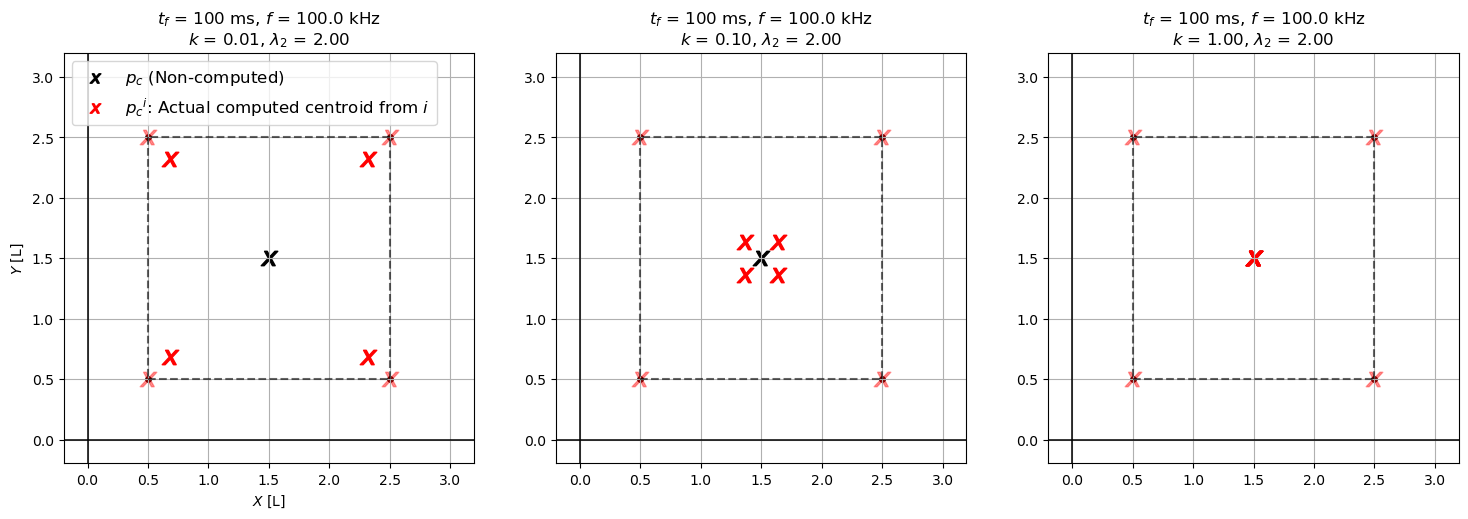

In [4]:
## Parameters #####
p = np.array([[1,1],[-1,1],[-1,-1],[1,-1]]) + np.array([1.5,1.5])
Z = ((1,2), (2,3), (3,4), (4,1))

dt = 0.01
its = 10 # iterations per dt

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_centroid_estimation(ax[0], p, Z, dt=dt, tf=0.1, its=its, k=0.01, 
                         legend=True,xlab=True,ylab=True)
plot_centroid_estimation(ax[1], p, Z, dt=dt, tf=0.1, its=its, k=0.1)
plot_centroid_estimation(ax[2], p, Z, dt=dt, tf=0.1, its=its, k=1)

# Show the plot!
plt.show()

In [6]:
anim = anim_centroid_estimation(p, Z, dt=0.01, tf=1, its=10, k=0.03)
HTML(anim.to_html5_video()) # It takes a loooot of time...

# writer = PillowWriter(fps=15, bitrate=1800)
# anim.save(os.path.join(OUTPUT_FOLDER, "centroid1.gif"),
#         writer = writer)

Simulating 100 frames...


  1%|          | 1/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


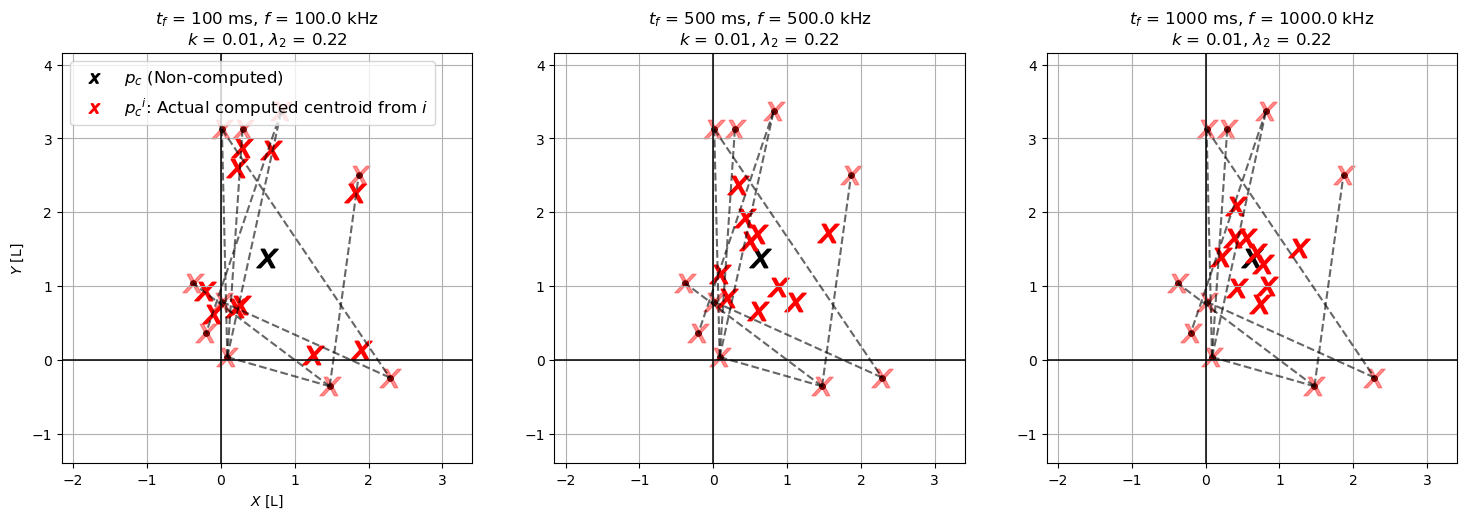

In [7]:
## Parameters #####
pc = np.array([1.2,1.5])
lims = np.array([2,2])

N = 10
p = XY_distrib(N,pc,lims)
Z = gen_random_graph(N)

dt = 0.01
its = 10 # iterations per dt

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_centroid_estimation(ax[0], p, Z, dt=dt, tf=0.1, its=its, k=0.01, 
                         legend=True,xlab=True,ylab=True)
plot_centroid_estimation(ax[1], p, Z, dt=dt, tf=0.5, its=its, k=0.01)
plot_centroid_estimation(ax[2], p, Z, dt=dt, tf=1, its=its, k=0.01)

# Show the plot!
plt.show()

In [9]:
anim = anim_centroid_estimation(p, Z, dt=0.01, tf=2, its=10, k=0.05)
HTML(anim.to_html5_video()) # It takes a loooot of time...

# writer = PillowWriter(fps=15, bitrate=1800)
# anim.save(os.path.join(OUTPUT_FOLDER, "centroid2.gif"),
#         writer = writer)

Simulating 200 frames...


  0%|          | 1/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:26<00:00, 13.03it/s]

## Ascending direction estimation

In [10]:
from scipy.integrate import odeint
from matplotlib.legend import Legend # legend artist

from toolbox.plot_utils import kw_def_patch, kw_def_arrow, unicycle_patch, vector2d
from toolbox.math_utils import unit_vec, L_sigma

# ----------------------------------------------------------------------
# Utility functions
# ----------------------------------------------------------------------

def build_B(list_edges, n):
    B = np.zeros((n,len(list_edges)))
    for i in range(len(list_edges)):
        B[list_edges[i][0]-1, i] = 1
        B[list_edges[i][1]-1, i] = -1
    return B

def build_L_from_B(B):
    L = B@B.T
    return L

def dyn_mu_estimation(lhat, t, Lb, k=1):
    lhat_dt = - k*(Lb.dot(lhat))
    return lhat_dt

# ----------------------------------------------------------------------
# Main function
# ----------------------------------------------------------------------

def plot_mu_estimation(ax, P, Z, sigma_field, dt, tf, its=10, k=1,
                             legend=False, xlab=False, ylab=False):
    """
    Funtion that visualises the estimation of the ascending direction
    """
    N = P.shape[0]

    pc = np.sum(P, axis=0)/N
    pb = P.flatten()
    X = P - pc

    # Evaluate the scalar field and compute the L_sigma (the not estimated one)
    sigma_values = sigma_field.value(P)
    mu_i_comp = L_sigma(X, sigma_values)

    mu_i = sigma_values[:,None] * X
    mu_i_b = mu_i.flatten()

    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)
    Lb = np.kron(L, np.eye(2))

    # Compute algebraic connectivity (lambda_2)
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[abs(eig_vals) > 1e-7])

    # Simulation -------------------------------------------------------
    t_steps = int(tf/dt)
    t = np.linspace(0, t_steps, int(its*t_steps+1))
    
    lhat_0 = np.copy(mu_i_b)
    lhat = odeint(dyn_mu_estimation, lhat_0, t, args=(Lb,k))

    mu0 = mu_i
    mu = lhat[-1].reshape(P.shape)
    # ------------------------------------------------------------------

    # Plotting ---------------------------------------------------------
    # Axis configuration
    scale = np.max(np.linalg.norm(X, axis=1))
    arr_scale = 0.8
    ds = scale + 1

    ax.axis([pc[0]-ds, pc[0]+ds, pc[1]-ds, pc[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = r"$N$ = {0:d}, $t_f$ = {1:.0f} ms, $f$ = {2:.1f} kHz".format(N, tf*1000, its/dt*tf) + "\n"
    title = title + r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(k,min_eig_val)
    ax.set_title(title)
    
    if xlab:
       ax.set_xlabel("$p_x$ [L]")
    if ylab:
        ax.set_ylabel("$p_y$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)

    alpha_edges = 0.8/(1+np.log(N))
    for edge in Z:
        ax.plot([P[edge[0]-1,0], P[edge[1]-1,0]], [P[edge[0]-1,1], P[edge[1]-1,1]], "k--", alpha=alpha_edges, zorder=-1)

    # Agents
    ax.scatter(P[:,0], P[:,1], color="k", s=15)
    # phi = np.pi/3
    # for n in range(N):
    #     icon = unicycle_patch(P[n,:], phi, "royalblue", **kw_def_patch(scale))
    #     ax.add_patch(icon)

    # Points
    ax.scatter(pc[0], pc[1], c="k", marker=r"$x$", s=arr_scale*100)

    # Gradient arrow and computed ascending direction L1
    sigma_field.draw_grad(pc, ax, kw_def_arrow(arr_scale))
    vector2d(ax, pc, unit_vec(mu_i_comp), c="blue", alpha=0.7, **kw_def_arrow(arr_scale))

    # Estimated ascending direction mu
    for n in range(N):
        vector2d(ax, P[n,:], unit_vec(mu0[n,:]), c="red", alpha=0.3, **kw_def_arrow(arr_scale))
        vector2d(ax, P[n,:], unit_vec(mu[n,:]), c="red", alpha=0.9, **kw_def_arrow(arr_scale))
    
    # Generate the legend
    if legend:
        arr1 = plt.scatter([],[],c='k',marker=r'$\uparrow$',s=60)
        arr2 = plt.scatter([],[],c='blue',marker=r'$\uparrow$',s=60)
        arr3 = plt.scatter([],[],c='red',marker=r'$\uparrow$',s=60)

        leg = Legend(ax, [arr1, arr2, arr3], 
                    [r"$\nabla\sigma$ (Non-computed)",
                     r"$L_1$ (Non-computed)",
                     r"$\mu_i$: Actual computed ascending direction from $i$",
                    ],
                    loc="upper left", prop={'size': 8}, ncol=1)

        ax.add_artist(leg)

def anim_mu_estimation(P, Z, sigma_field, dt, tf, its=10, k=1, fps=30):
    """
    Funtion to animate the ascending direction estimation
    """
    N = P.shape[0]

    pc = np.sum(P, axis=0)/N
    pb = P.flatten()
    X = P - pc

    # Evaluate the scalar field and compute the L_sigma (the not estimated one)
    sigma_values = sigma_field.value(P)
    mu_i_comp = L_sigma(X, sigma_values)

    mu_i = sigma_values[:,None] * X
    mu_i_b = mu_i.flatten()

    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)
    Lb = np.kron(L, np.eye(2))

    # Compute algebraic connectivity (lambda_2)
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[abs(eig_vals) > 1e-7])

    # Simulation -------------------------------------------------------
    t_steps = int(tf/dt)
    t = np.linspace(0, t_steps, int(its*t_steps+1))
    
    mu_0 = np.copy(mu_i_b)
    mu = odeint(dyn_mu_estimation, mu_0, t, args=(Lb,k))

    mu = mu.reshape((int(its*t_steps+1), N, 2))
    # ------------------------------------------------------------------

    # -- Animation --
    fig = plt.figure()
    ax = fig.subplots()

    # Axis configuration
    scale = np.max(np.linalg.norm(X, axis=1))
    arr_scale = 0.8
    ds = scale + 1

    ax.axis([pc[0]-ds, pc[0]+ds, pc[1]-ds, pc[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = r"$N$ = {0:d}, $t_f$ = {1:.0f} ms, $f$ = {2:.1f} kHz".format(N, tf*1000, its/dt*tf) + "\n"
    title = title + r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(k,min_eig_val)
    ax.set_title(title)
    
    ax.set_xlabel("$p_x$ [L]")
    ax.set_ylabel("$p_y$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)

    alpha_edges = 0.8/(1+np.log(N))
    for edge in Z:
        ax.plot([P[edge[0]-1,0], P[edge[1]-1,0]], [P[edge[0]-1,1], P[edge[1]-1,1]], "k--", alpha=alpha_edges, zorder=-1)

    # Agents
    ax.scatter(P[:,0], P[:,1], color="k", s=15)

    # Points
    ax.scatter(pc[0], pc[1], c="k", marker=r"$x$", s=arr_scale*100)

    # Gradient arrow and computed ascending direction L1
    sigma_field.draw_grad(pc, ax, kw_def_arrow(arr_scale))
    vector2d(ax, pc, unit_vec(mu_i_comp), c="blue", alpha=0.7, **kw_def_arrow(arr_scale))

    # Estimated ascending direction mu
    quiv_list = []
    for n in range(N):
        vector2d(ax, P[n,:], unit_vec(mu[0,n,:])*1.2, c="red", alpha=0.3, **kw_def_arrow(arr_scale))
        quiv = vector2d(ax, P[n,:], unit_vec(mu[0,n,:]), c="red", alpha=0.9, **kw_def_arrow(arr_scale))
        quiv_list.append(quiv)
    
    # Generate the legend
    arr1 = plt.scatter([],[],c='k',marker=r'$\uparrow$',s=60)
    arr2 = plt.scatter([],[],c='blue',marker=r'$\uparrow$',s=60)
    arr3 = plt.scatter([],[],c='red',marker=r'$\uparrow$',s=60)

    leg = Legend(ax, [arr1, arr2, arr3], 
                [r"$\nabla\sigma$ (Non-computed)",
                    r"$L_1$ (Non-computed)",
                    r"$\mu_i$: Actual computed ascending direction from $i$",
                ],
                loc="upper left", prop={'size': 8}, ncol=1)

    ax.add_artist(leg)

    # -- Building the animation --
    anim_frames = t_steps

    # Function to update the animation
    def animate(i):
        # Update the centroid estimation markers
        li = its*i
        mu_list = unit_vec(mu[li,:,:])
        for n in range(N):
            quiv_list[n].set_data(dx=mu_list[n,0], dy=mu_list[n,1])

        # Update the title
        title = r"$t_f$ = {0:.0f} ms, $f$ = {1:.1f} kHz".format((dt*i)*1000, its/dt*tf) + "\n"
        title = title + r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(k, min_eig_val)
        ax.set_title(title)

    # Generate the animation
    print("Simulating {0:d} frames...".format(anim_frames))
    anim = FuncAnimation(fig, animate, frames=tqdm(range(anim_frames), initial=1, position=0), 
                         interval=1/fps*1000)
    anim.embed_limit = 40

    # Close plots and return the animation class to be compiled
    plt.close()
    return anim

### Some examples

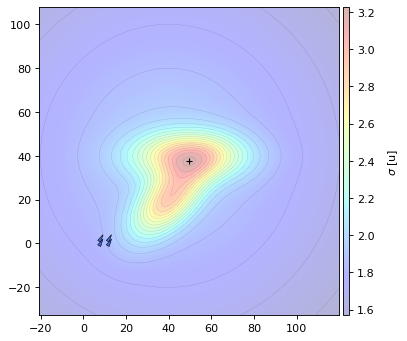

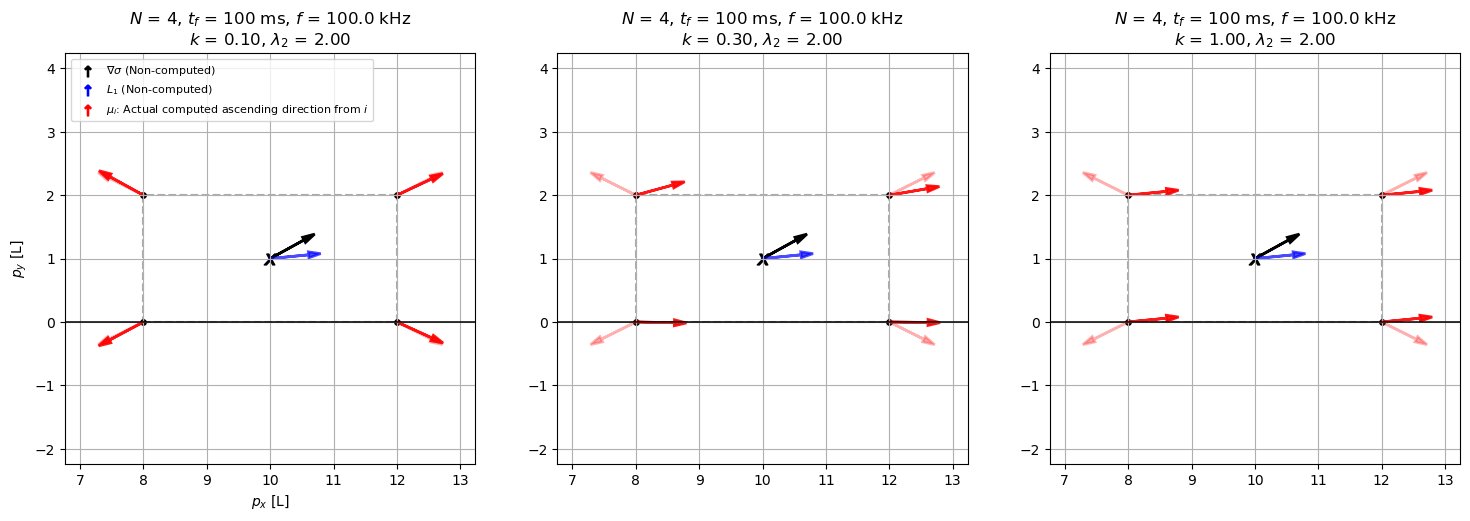

In [11]:
## Parameters #####
p = np.array([[2,1],[-2,1],[-2,-1],[2,-1]]) + np.array([10,1])
Z = ((1,2), (2,3), (3,4), (4,1))
N = p.shape[0]

dt = 0.01
its = 10 # iterations per dt

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_func = sigma_nonconvex(k=0.04, dev=dev, mu=mu)
sigma_field = sigma(sigma_func)

# Draw the scalar field
fig = plt.figure(figsize=(5, 5), dpi=80)
ax = fig.subplots()
sigma_field.draw(fig=fig, ax=ax, xlim=70, ylim=70, contour_levels=20)

# Agents
phi = np.pi/3
for n in range(N):
    icon = unicycle_patch(p[n,:], phi, "royalblue", size=3)
    ax.add_patch(icon)

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_mu_estimation(ax[0], p, Z, sigma_field, dt=dt, tf=0.1, its=its, k=0.1, 
                         legend=True,xlab=True,ylab=True)
plot_mu_estimation(ax[1], p, Z, sigma_field, dt=dt, tf=0.1, its=its, k=0.3)
plot_mu_estimation(ax[2], p, Z, sigma_field, dt=dt, tf=0.1, its=its, k=1)

# Show the plot!
plt.show()

In [12]:
anim = anim_mu_estimation(p, Z, sigma_field, dt=dt, tf=1, its=its, k=0.05)
HTML(anim.to_html5_video()) # It takes a loooot of time...

# writer = PillowWriter(fps=15, bitrate=1800)
# anim.save(os.path.join(OUTPUT_FOLDER, "ascdir1.gif"),
#         writer = writer)

Simulating 100 frames...


  1%|          | 1/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:28<00:00,  7.63it/s]

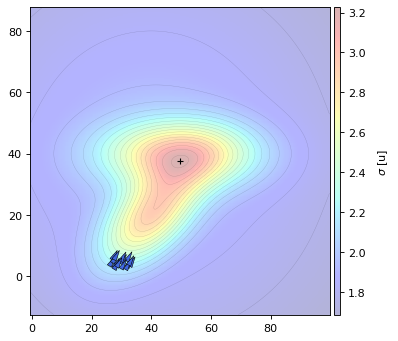

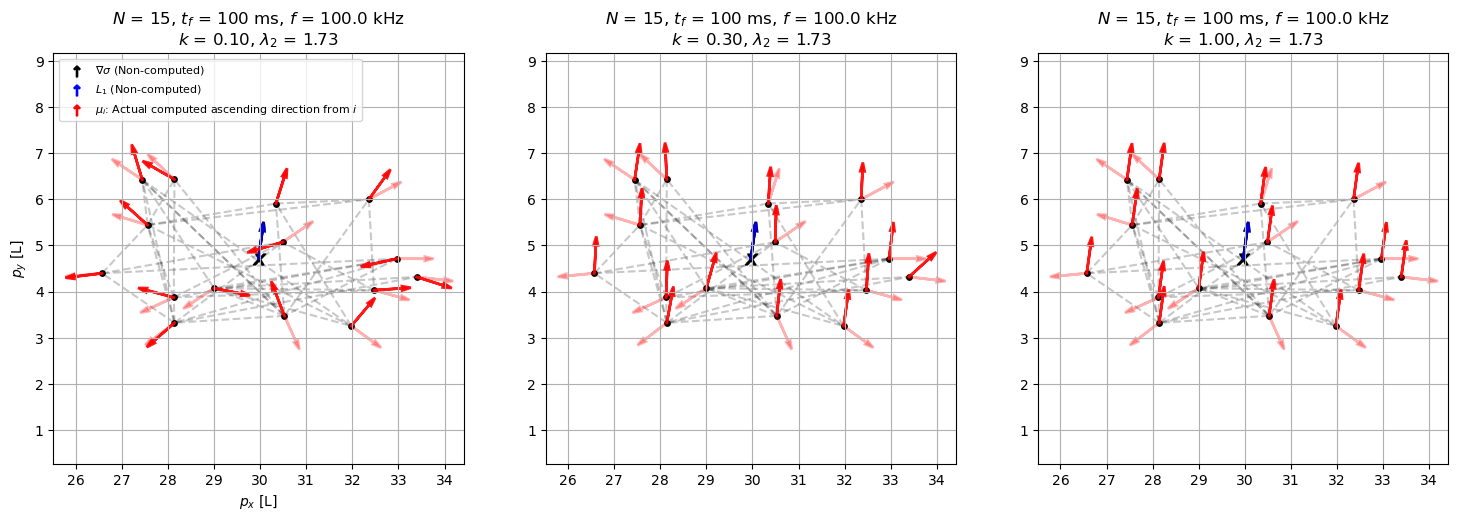

In [13]:
## Parameters #####
pc = np.array([30,5])
lims = np.array([4,2])

N = 15
p = XY_distrib(N,pc,lims)
Z = gen_random_graph(N, rounds=3)

dt = 0.01
its = 10 # iterations per dt

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_func = sigma_nonconvex(k=0.04, dev=dev, mu=mu)
sigma_field = sigma(sigma_func)

# Draw the scalar field
fig = plt.figure(figsize=(5, 5), dpi=80)
ax = fig.subplots()
sigma_field.draw(fig=fig, ax=ax, xlim=50, ylim=50, contour_levels=20)

# Agents
phi = np.pi/3
for n in range(N):
    icon = unicycle_patch(p[n,:], phi, "royalblue", size=3)
    ax.add_patch(icon)

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_mu_estimation(ax[0], p, Z, sigma_field, dt=dt, tf=0.1, its=its, k=0.1, 
                         legend=True,xlab=True,ylab=True)
plot_mu_estimation(ax[1], p, Z, sigma_field, dt=dt, tf=0.1, its=its, k=0.3)
plot_mu_estimation(ax[2], p, Z, sigma_field, dt=dt, tf=0.1, its=its, k=1)

# Show the plot!
plt.show()

In [14]:
anim = anim_mu_estimation(p, Z, sigma_field, dt=dt, tf=1, its=its, k=0.05)
HTML(anim.to_html5_video()) # It takes a loooot of time...

writer = PillowWriter(fps=15, bitrate=1800)
anim.save(os.path.join(OUTPUT_FOLDER, "ascdir2.gif"),
        writer = writer)

Simulating 100 frames...


  1%|          | 1/100 [00:00<?, ?it/s]

 99%|█████████▉| 99/100 [00:08<00:00, 12.53it/s]

 99%|█████████▉| 99/100 [00:22<00:00, 12.53it/s]

## Centroid + ascending direction estimation

In [2]:
from simulator.simulator import simulator
from plotter.plotter import plotter

### Basic example

In [12]:
## Parameters #####
pc = np.array([5,60])
lims = np.array([4,4])

N = 10
p = XY_distrib(N,pc,lims)
phi = np.random.rand(N) * np.pi
Z = gen_random_graph(N, rounds=3)

v = 1

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_func = sigma_nonconvex(k=0.04, dev=dev, mu=mu)
sigma_field = sigma(sigma_func)

In [13]:
# ----------------------------------------------------------------------
# Generating the simulator class
# ----------------------------------------------------------------------
dt = 1/60
q0 = [p, v, phi]

sim = simulator(q0, Z, sigma_field, dt=dt, kc=0.1, kl=2, its_c=5, its_l=10)

# ----------------------------------------------------------------------
# Execute the simulation given a desired final time stamp
# ----------------------------------------------------------------------
tf = 80
its = int(tf/dt)

for it in tqdm(range(its)): 
    if it == 500:
        sim.kill_agents([2,5,7])
    sim.int_step()

100%|██████████| 4800/4800 [00:08<00:00, 541.23it/s]


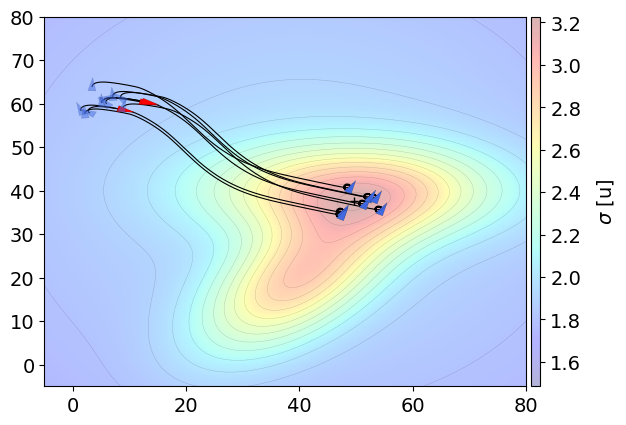

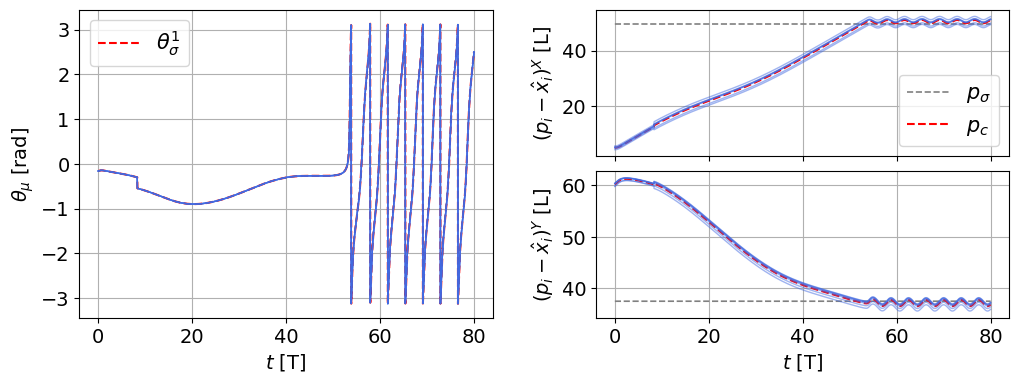

In [14]:
plotter_sim = plotter(sim)

lims=[-5,80]
plotter_sim.plot_simulation(xlim=lims, ylim=lims)
plotter_sim.plot_estimations()

### One team splites in two

In [15]:
## Parameters #####
pc = np.array([-20,-20])
lims = np.array([15,15])

N = 9
p = XY_distrib(N,pc,lims)
phi = np.random.rand(N) * np.pi
Z = [(1,2), (2,3), (3,4), (4,1), 
     (4,5), (5,3), (5,6), (9,5),
     (6,7), (7,8), (8,9), (9,6)]

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_func = sigma_nonconvex(k=0.04, dev=dev, mu=mu)
sigma_field = sigma(sigma_func)

In [16]:
# ----------------------------------------------------------------------
# Generating the simulator class
# ----------------------------------------------------------------------
dt = 1/60
q0 = [p, 2, phi]

sim = simulator(q0, Z, sigma_field, dt=dt, kc=0.1, kl=1, its_c=5, its_l=10)

# ----------------------------------------------------------------------
# Execute the simulation given a desired final time stamp
# ----------------------------------------------------------------------
tf = 60
its = int(tf/dt)

for it in tqdm(range(its)): 
    if it == 1000:
        sim.kill_agents([4])
    sim.int_step()

100%|██████████| 3600/3600 [00:04<00:00, 810.48it/s] 


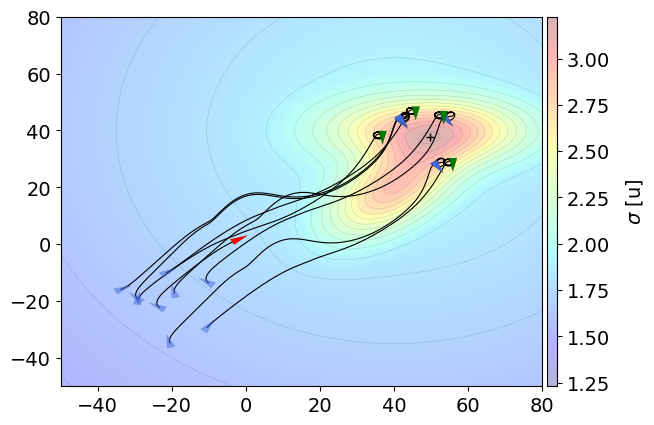

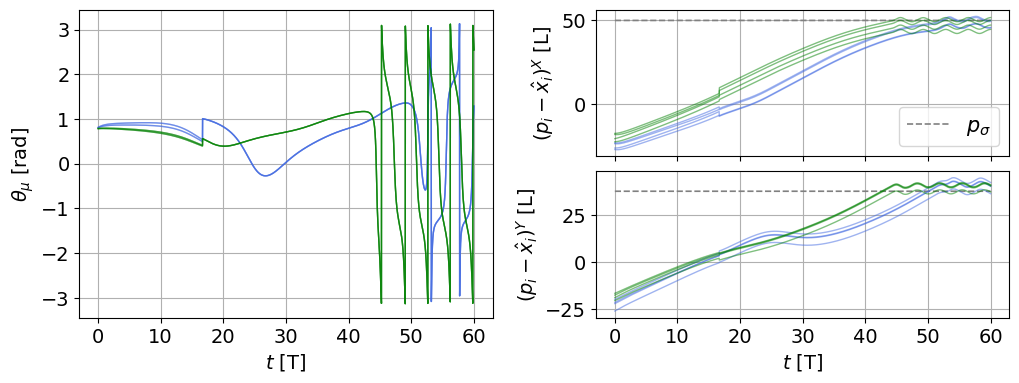

In [17]:
plotter_sim = plotter(sim)

lims=[-50,80]
team_tags = [0,0,0,0,1,1,1,1,1]
plotter_sim.plot_simulation(team_tags, xlim=lims, ylim=lims)
plotter_sim.plot_estimations(team_tags)